# Bonus1: Parallel Algorithms

### Name: Malav Shastri


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.24064052 -0.10390282  0.07243654  0.08851909  0.00806381  0.02970792
   0.03781396 -0.14001248]]
test std = 
[[0.84757459 0.95455915 0.82685375 0.92289492 1.02374169 0.90527948
  0.88677758 0.98099398]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


## Worker Node

In [5]:
class Worker:
    def __init__(self, x, y, q, alpha, lam, beta):
        self.x = x #s-by-d local feature matrix
        self.y = y #s-by-1 local label matrix
        self.s = x.shape[0] #number of local samples
        self.d = x.shape[1] #number of features
        self.w = numpy.zeros((self.d, 1)) #d-by-1 model parameter vecotr
        self.q = q #Number of times local gradient to be performed
        self.v = numpy.zeros((self.d, 1)) #d-by1 momentum
        self.alpha = alpha #Local learning rate
        self.initial_w = numpy.zeros((self.d, 1)) #To store the w broadcasted by server for finding direction at the end
        self.lam = lam #regularization parameter
        self.beta = beta #momentum parameter 
    #Set the model parameters to the latest
    def set_param(self, w):
        self.w = w
        self.initial_w = w
    
    #compute the local loss
    def loss(self):
        yx = numpy.multiply(self.y, self.x) #s-by-d matrix
        yxw = numpy.dot(yx, self.w) #s-by-1 matrix
        vec1 = numpy.exp(-yxw) #s-by-1 matrix
        vec2 = numpy.log(1 + vec1) #s-by-1 matrix
        reg = self.lam / 2*numpy.sum(self.w * self.w)
        losses = numpy.sum(vec2)/self.s + reg #loss function
        return losses
    
    #Compute the local gradient 
    def gradient(self):
        yx = numpy.multiply(self.y, self.x) # s-by-d
        yxw = numpy.dot(yx, self.w) # s-by-1
        vec1 = numpy.exp(yxw) # s-by-1
        vec2 = numpy.divide(yx, 1+vec1) # s-by-d
        reg = self.lam / 2*numpy.sum(self.w * self.w)
        g = -numpy.mean(vec2, axis=0).reshape(self.d, 1)+reg # d-by-1
        return g

    
    #Compute q gradient 
    def gradient_descent_local(self):
        for i in range(self.q):
            gradient = self.gradient()
            self.v = self.beta*self.v + gradient
            self.w -= self.alpha * self.v
            losses = self.loss()
            #print("local gradient ", gradient)
            print("local objective function value ", losses)
            #print("local w", self.w)
        return self.w
    
    #Compute Stochastic gradient descent
    def sgd(self, i, x_rand, y_rand):
        import numpy as np
        xi = x_rand[i,:]
        yi = float(y_rand[i,:])
        # calculate the stochastic gradient and local worker loss
        d = xi.shape[0]
        yx = yi * xi
        yxw = float(np.dot(yx, self.w))
        loss = np.log(1 + np.exp(-yxw))
        reg = lam / 2 * np.sum(self.w * self.w)
        obj = loss + reg
        gradient = -yx.T / (1 + np.exp(yxw))
        gradient = gradient + lam * self.w
        return gradient, obj
    
    #Compute q stochastic gradients 
    def stochgradient_descent_local(self):
        import numpy as np
        for i in range(self.q):
            rand_indices = np.random.permutation(self.s)
            x_rand = self.x[rand_indices,:]
            y_rand = self.y[rand_indices,:]
            stcobj = 0
            for i in range(self.s):
                gradient, obj = self.sgd(i, x_rand, y_rand)
                self.w -= self.alpha * gradient
                stcobj+=obj
            self.alpha *= 0.9 # decrease step size
            stcobj /= self.s
            #self.v = self.beta*self.v + gradient
            #self.w -= self.alpha * self.v
            #losses = self.loss()
            #print("local gradient ", gradient)
            print("local objective function value ", stcobj)
            #print("local w", self.w)
        return self.w
    
    #Find direction to be sent back to server
    def find_direction(self):
        pk = self.initial_w - self.gradient_descent_local()
        return pk
    
    #Find direction to be sent back to server stochastic gradient 
    def find_stochdirection(self):
        pk = self.initial_w - self.stochgradient_descent_local()
        return pk
        

## Server Node

In [6]:
class Server:
    def __init__(self, m, n, d, alpha, lam):
        self.m = m #number of worker nodes
        self.n = n #number of training samples
        self.d = d #number of features
        self.w = numpy.zeros((d, 1)) #d-by-1 model parameter vector
        self.pk = numpy.zeros((d, 1)) #directions recieved from different workers
        self.alpha = alpha #Server Learning rate
        self.lam = lam #Server reg parameter
        #self.g = numpy.zeros((d, 1)) #d-by-1 gradient
        #self.v = numpy.zeros((d, 1)) #d-by1 momentum
        self.loss = 0 #loss function value
        #self.obj = 0 #objective function value
    
    def broadcast(self):
        return self.w
    
    def aggregate(self, pk, losses):
        self.pk = numpy.mean(numpy.array(pk), axis=0)
        self.loss = sum(losses)
        #self.g = numpy.zeros((self.d, 1))
        #self.loss = 0
        #for k in range(self.m):
            #self.pk += pk[k]
            #self.loss += losses[k]
        #self.pk = self.pk/self.m
        
    def update(self):
        self.w = self.w - self.alpha*self.pk
        self.alpha *= 0.9 # decrease step size
            
    #Compute the objective function (sum of loss and regularization)
    def objective(self):
        reg = self.lam/2 * numpy.sum(self.w*self.w)
        self.obj = self.loss/self.m + reg
        return self.obj
    
    

## Initialization for q=1

In [7]:
import math

#Create a server and m worker nodes
def create_server_workers(m, x, y, q, alpha, lam, beta):
    n, d = x.shape
    s = math.floor(n / m)
    server = Server(m, n, d, alpha, lam)
    workers = []
    
    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        #print(x.shape)
        worker = Worker(x[indices, :], y[indices, :], q, alpha, lam, beta)
        workers.append(worker)
        
    return server, workers

m = 4 #number of worker nodes
q = 1
lam = 1E-4 #regularization parameter
alpha = 0.01 #learning rate
beta = 0.9 #momentum parameter 
server, workers = create_server_workers(m, x_train, y_train, q, alpha, lam, beta)

In [8]:
max_epoch = 50 #number of epochs
communication1 = 0 #number of communication
objective_val_1 = []
for t in range(max_epoch):
    print("----------------------------------epoch"+str(t)+"-------------------------------")
    #step 1: broadcast
    w = server.broadcast()
    communication1 = communication1+1
    for i in range(m):
        workers[i].set_param(w)
        
    #step 2: workers' local computations
    pk_1 = []
    losses_1 = []
    for i in range(m):
        print("Worker "+str(i+1))
        g = workers[i].find_direction()
        pk_1.append(g)
        l = workers[i].loss()
        losses_1.append(l)
        
    #step 3: aggregate the workers' outputs
    server.aggregate(pk_1, losses_1)
    communication1= communication1+1
    
    #step 4: server update the model parameters
    server.update() #compute gradient
    obj = server.objective() #compute objective function
    objective_val_1.append(obj)
    print('Objective function value = '+str(obj))

----------------------------------epoch0-------------------------------
Worker 1
local objective function value  0.6917157621627363
Worker 2
local objective function value  0.6904441634870078
Worker 3
local objective function value  0.6896352609652894
Worker 4
local objective function value  0.6883353932650647
Objective function value = 0.6900326547840892
----------------------------------epoch1-------------------------------
Worker 1
local objective function value  0.6855052960943923
Worker 2
local objective function value  0.6829710477658055
Worker 3
local objective function value  0.6820863233355132
Worker 4
local objective function value  0.6795072141987508
Objective function value = 0.6825175516693937
----------------------------------epoch2-------------------------------
Worker 1
local objective function value  0.6753805661061458
Worker 2
local objective function value  0.6716709407008434
Worker 3
local objective function value  0.6713579981820101
Worker 4
local objective functio

## Initialization for q=8

In [9]:
import math

#Create a server and m worker nodes
def create_server_workers(m, x, y, q, alpha, lam, beta):
    n, d = x.shape
    s = math.floor(n / m)
    server = Server(m, n, d, alpha, lam)
    workers = []
    
    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        #print(x.shape)
        worker = Worker(x[indices, :], y[indices, :], q, alpha, lam, beta)
        workers.append(worker)
        
    return server, workers

m = 4 #number of worker nodes
q = 8
lam = 1E-4 #regularization parameter
alpha = 0.01 #learning rate
beta = 0.9 #momentum parameter 
server, workers = create_server_workers(m, x_train, y_train, q, alpha, lam, beta)

In [10]:
max_epoch = 50 #number of epochs
objective_val_8 = []
communication8 = 0
for t in range(max_epoch):
    print("----------------------------------epoch"+str(t)+"-------------------------------")
    #step 1: broadcast
    w = server.broadcast()
    communication8 = communication8+1
    for i in range(m):
        workers[i].set_param(w)
        
    #step 2: workers' local computations
    pk_8 = []
    losses_8 = []
    for i in range(m):
        print("Worker "+str(i+1))
        g = workers[i].find_direction()
        pk_8.append(g)
        l = workers[i].loss()
        losses_8.append(l)
        
    #step 3: aggregate the workers' outputs
    server.aggregate(pk_8, losses_8)
    communication8 = communication8+1
    
    #step 4: server update the model parameters
    server.update() #compute gradient
    obj = server.objective() #compute objective function
    objective_val_8.append(obj)
    print('Objective function value = '+str(obj))

----------------------------------epoch0-------------------------------
Worker 1
local objective function value  0.6917157621627363
local objective function value  0.6890169487218846
local objective function value  0.6852151659551917
local objective function value  0.680471348670085
local objective function value  0.6749399240614846
local objective function value  0.6687665414424083
local objective function value  0.6620864376563569
local objective function value  0.6550233444032404
Worker 2
local objective function value  0.657613779736934
local objective function value  0.6554760392453689
local objective function value  0.6524699457909101
local objective function value  0.6487278493043973
local objective function value  0.644377120921779
local objective function value  0.6395378475175921
local objective function value  0.6343211594236341
local objective function value  0.6288281123506139
Worker 3
local objective function value  0.6373037369276304
local objective function value  0.635

local objective function value  0.4532782019917862
local objective function value  0.4531327266968408
Worker 3
local objective function value  0.4943833849938473
local objective function value  0.4932839580432675
local objective function value  0.49220790812201126
local objective function value  0.491158596618744
local objective function value  0.490138721759833
local objective function value  0.489150386173111
local objective function value  0.4881951616299632
local objective function value  0.48727415042907546
Worker 4
local objective function value  0.5077700283814245
local objective function value  0.5071307875790979
local objective function value  0.5065000718703908
local objective function value  0.5058791184733145
local objective function value  0.5052689750454351
local objective function value  0.5046705177900606
local objective function value  0.5040844683444611
local objective function value  0.5035114094715379
Objective function value = 0.4732892513316501
-------------------

local objective function value  0.4873311916687995
Worker 4
local objective function value  0.5077677783656495
local objective function value  0.5071285669158314
local objective function value  0.5064978914158873
local objective function value  0.5058769856090739
local objective function value  0.5052668942509495
local objective function value  0.5046684911455951
local objective function value  0.5040824959704182
local objective function value  0.5035094899105848
Objective function value = 0.4732872554671732
----------------------------------epoch32-------------------------------
Worker 1
local objective function value  0.4585803447569342
local objective function value  0.45705193148073686
local objective function value  0.45555339202743267
local objective function value  0.4540892143533906
local objective function value  0.4526630902503472
local objective function value  0.45127798930190777
local objective function value  0.4499362295622862
local objective function value  0.4486395446

local objective function value  0.4512772653910391
local objective function value  0.44993551544905364
local objective function value  0.4486388400974637
Worker 2
local objective function value  0.4541656379562988
local objective function value  0.4540074321860796
local objective function value  0.45385097085475984
local objective function value  0.4536964903517911
local objective function value  0.45354418706117233
local objective function value  0.4533942215614965
local objective function value  0.4532467225396215
local objective function value  0.4531017904157629
Worker 3
local objective function value  0.49445030563364645
local objective function value  0.493349594254886
local objective function value  0.49227225839087674
local objective function value  0.49122166632474284
local objective function value  0.49020052217602816
local objective function value  0.48921093353439066
local objective function value  0.48825447627674257
local objective function value  0.4873322560286155
Worke

## Plot the curve

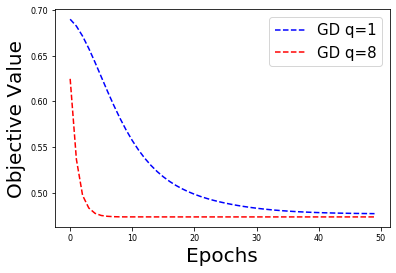

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd_1 = range(len(objective_val_1))
epochs_gd_8 = range(len(objective_val_8))

#epochs_gd_1 = range(int(communication1/2))
#epochs_gd_8 = range(int(communication1/2))


line0, = plt.plot(epochs_gd_1, objective_val_1, '--b', LineWidth=1.5)
line1, = plt.plot(epochs_gd_8, objective_val_8, '--r', LineWidth=1.5)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=8)
plt.yticks(FontSize=8)
plt.legend([line0, line1], ['GD q=1','GD q=8'], fontsize=15)
plt.show()

## Initialization for q=1 for SGD

In [12]:
import math

#Create a server and m worker nodes
def create_server_workers(m, x, y, q, alpha, lam, beta):
    n, d = x.shape
    s = math.floor(n / m)
    server = Server(m, n, d, alpha, lam)
    workers = []
    
    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        #print(x.shape)
        worker = Worker(x[indices, :], y[indices, :], q, alpha, lam, beta)
        workers.append(worker)
        
    return server, workers

m = 4 #number of worker nodes
q = 1
lam = 1E-4 #regularization parameter
alpha = 0.01 #learning rate
beta = 0.9 #momentum parameter 
server, workers = create_server_workers(m, x_train, y_train, q, alpha, lam, beta)

In [13]:
max_epoch = 50 #number of epochs
sgd_objective_val_1 = []
for t in range(max_epoch):
    print("----------------------------------epoch"+str(t)+"-------------------------------")
    #step 1: broadcast
    w = server.broadcast()
    for i in range(m):
        workers[i].set_param(w)
        
    #step 2: workers' local computations
    sgd_pk_1 = []
    sgd_losses_1 = []
    for i in range(m):
        print("Worker "+str(i+1))
        g = workers[i].find_stochdirection()
        sgd_pk_1.append(g)
        l = workers[i].loss()
        sgd_losses_1.append(l)
        
    #step 3: aggregate the workers' outputs
    server.aggregate(sgd_pk_1, sgd_losses_1)
    
    #step 4: server update the model parameters
    server.update() #compute gradient
    obj = server.objective() #compute objective function
    sgd_objective_val_1.append(obj)
    print('Objective function value = '+str(obj))
    

----------------------------------epoch0-------------------------------
Worker 1
local objective function value  0.6204452084962938
Worker 2
local objective function value  0.5490730094716931
Worker 3
local objective function value  0.5359895049722534
Worker 4
local objective function value  0.5257679430635525
Objective function value = 0.525464510850209
----------------------------------epoch1-------------------------------
Worker 1
local objective function value  0.4908031030753445
Worker 2
local objective function value  0.48322120899934823
Worker 3
local objective function value  0.5025199507592315
Worker 4
local objective function value  0.5121700086336232
Objective function value = 0.48375090817963434
----------------------------------epoch2-------------------------------
Worker 1
local objective function value  0.47413795681378923
Worker 2
local objective function value  0.46872246169350235
Worker 3
local objective function value  0.49627974572583583
Worker 4
local objective fun

local objective function value  0.4918728779765078
Worker 4
local objective function value  0.5059500394818103
Objective function value = 0.476043924079908
----------------------------------epoch26-------------------------------
Worker 1
local objective function value  0.45574526988587294
Worker 2
local objective function value  0.45394663381751144
Worker 3
local objective function value  0.49181314928692366
Worker 4
local objective function value  0.5059040947936113
Objective function value = 0.4760892182407831
----------------------------------epoch27-------------------------------
Worker 1
local objective function value  0.4556778978119995
Worker 2
local objective function value  0.45389897126483875
Worker 3
local objective function value  0.491764932073725
Worker 4
local objective function value  0.5058638075714176
Objective function value = 0.47612710749590614
----------------------------------epoch28-------------------------------
Worker 1
local objective function value  0.455633

## Initialization for q=8 for SGD

In [14]:
import math

#Create a server and m worker nodes
def create_server_workers(m, x, y, q, alpha, lam, beta):
    n, d = x.shape
    s = math.floor(n / m)
    server = Server(m, n, d, alpha, lam)
    workers = []
    
    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        #print(x.shape)
        worker = Worker(x[indices, :], y[indices, :], q, alpha, lam, beta)
        workers.append(worker)
        
    return server, workers

m = 4 #number of worker nodes
q = 8
lam = 1E-4 #regularization parameter
alpha = 0.01 #learning rate
beta = 0.9 #momentum parameter 
server, workers = create_server_workers(m, x_train, y_train, q, alpha, lam, beta)

In [15]:
max_epoch = 50 #number of epochs
sgd_objective_val_8 = []
for t in range(max_epoch):
    print("----------------------------------epoch"+str(t)+"-------------------------------")
    #step 1: broadcast
    w = server.broadcast()
    for i in range(m):
        workers[i].set_param(w)
        
    #step 2: workers' local computations
    sgd_pk_8 = []
    sgd_losses_8 = []
    for i in range(m):
        print("Worker "+str(i+1))
        g = workers[i].find_stochdirection()
        sgd_pk_8.append(g)
        l = workers[i].loss()
        sgd_losses_8.append(l)
        
    #step 3: aggregate the workers' outputs
    server.aggregate(sgd_pk_8, sgd_losses_8)
    
    #step 4: server update the model parameters
    server.update() #compute gradient
    obj = server.objective() #compute objective function
    sgd_objective_val_8.append(obj)
    print('Objective function value = '+str(obj))

----------------------------------epoch0-------------------------------
Worker 1
local objective function value  0.6212906958432007
local objective function value  0.5361455332637133
local objective function value  0.4994512115736954
local objective function value  0.47868103153906816
local objective function value  0.4660198204552059
local objective function value  0.4576740960543166
local objective function value  0.4515814146700695
local objective function value  0.4471831985907202
Worker 2
local objective function value  0.49122897002445887
local objective function value  0.47666010476672893
local objective function value  0.46957173000221325
local objective function value  0.46495570390403695
local objective function value  0.46204531655113046
local objective function value  0.4597433874711581
local objective function value  0.458064208269643
local objective function value  0.4567222493535447
Worker 3
local objective function value  0.4950430007475276
local objective function valu

local objective function value  0.4613589548160205
local objective function value  0.4611270880010457
local objective function value  0.46091959835255947
Worker 2
local objective function value  0.45369089333048995
local objective function value  0.4536499209361479
local objective function value  0.45361316211960523
local objective function value  0.45358020387564507
local objective function value  0.4535506266153795
local objective function value  0.453524088538379
local objective function value  0.4535002488958205
local objective function value  0.4534788459720681
Worker 3
local objective function value  0.4916723451250638
local objective function value  0.4914338456350077
local objective function value  0.4912214937282454
local objective function value  0.4910319492636102
local objective function value  0.49086280029490614
local objective function value  0.4907116187092747
local objective function value  0.4905764794044439
local objective function value  0.4904555348832476
Worker 4


local objective function value  0.49092756568429075
local objective function value  0.490924478886988
local objective function value  0.49092170113975264
local objective function value  0.4909192015046953
local objective function value  0.49091695206273717
local objective function value  0.49091492775595846
local objective function value  0.49091310602881055
Worker 4
local objective function value  0.5012663099411887
local objective function value  0.5012645831179563
local objective function value  0.5012630291336506
local objective function value  0.5012616306742206
local objective function value  0.5012603721515273
local objective function value  0.5012592395551564
local objective function value  0.501258220288313
local objective function value  0.5012573030076115
Objective function value = 0.47695866401776804
----------------------------------epoch11-------------------------------
Worker 1
local objective function value  0.46160980831994997
local objective function value  0.46160727

local objective function value  0.5012600598181485
local objective function value  0.5012600391479753
local objective function value  0.5012600205448402
local objective function value  0.5012600038020358
local objective function value  0.5012599887335267
local objective function value  0.501259975171881
Objective function value = 0.47696507651205244
----------------------------------epoch16-------------------------------
Worker 1
local objective function value  0.4616009057925347
local objective function value  0.461600868347707
local objective function value  0.46160083464739043
local objective function value  0.4616008043171325
local objective function value  0.46160077701992036
local objective function value  0.46160075245244636
local objective function value  0.4616007303417325
local objective function value  0.46160071044210066
Worker 2
local objective function value  0.453530246999022
local objective function value  0.453530243150117
local objective function value  0.453530239686

local objective function value  0.4616007731462715
local objective function value  0.4616007726979639
local objective function value  0.461600772294487
local objective function value  0.461600771931358
local objective function value  0.46160077160454155
local objective function value  0.46160077131040705
Worker 2
local objective function value  0.4535302325827134
local objective function value  0.45353023252582336
local objective function value  0.4535302324746217
local objective function value  0.45353023242854124
local objective function value  0.45353023238706835
local objective function value  0.45353023234974243
local objective function value  0.4535302323161492
local objective function value  0.4535302322859157
Worker 3
local objective function value  0.4909199120879018
local objective function value  0.4909199117654355
local objective function value  0.49091991147521546
local objective function value  0.49091991121401757
local objective function value  0.4909199109789397
local o

local objective function value  0.4535302323667362
local objective function value  0.45353023236618484
local objective function value  0.4535302323656879
local objective function value  0.4535302323652409
Worker 3
local objective function value  0.49091991106089117
local objective function value  0.49091991105612476
local objective function value  0.4909199110518349
local objective function value  0.4909199110479743
local objective function value  0.4909199110444997
local objective function value  0.4909199110413727
local objective function value  0.4909199110385578
local objective function value  0.49091991103602517
Worker 4
local objective function value  0.5012600152775368
local objective function value  0.5012600152751369
local objective function value  0.5012600152729768
local objective function value  0.501260015271033
local objective function value  0.5012600152692834
local objective function value  0.5012600152677085
local objective function value  0.5012600152662917
local obje

local objective function value  0.4909199110457118
local objective function value  0.4909199110456413
local objective function value  0.4909199110455778
local objective function value  0.4909199110455207
local objective function value  0.4909199110454693
local objective function value  0.49091991104542315
local objective function value  0.4909199110453818
local objective function value  0.4909199110453441
Worker 4
local objective function value  0.501260015268916
local objective function value  0.5012600152688804
local objective function value  0.5012600152688484
local objective function value  0.5012600152688201
local objective function value  0.5012600152687943
local objective function value  0.5012600152687707
local objective function value  0.5012600152687496
local objective function value  0.5012600152687307
Objective function value = 0.4769651727035448
----------------------------------epoch32-------------------------------
Worker 1
local objective function value  0.4616007722237

local objective function value  0.4909199110454889
local objective function value  0.49091991104548793
local objective function value  0.49091991104548693
local objective function value  0.49091991104548616
local objective function value  0.4909199110454853
local objective function value  0.4909199110454847
local objective function value  0.4909199110454841
local objective function value  0.49091991104548355
Worker 4
local objective function value  0.5012600152687867
local objective function value  0.5012600152687859
local objective function value  0.5012600152687854
local objective function value  0.5012600152687849
local objective function value  0.5012600152687849
local objective function value  0.5012600152687842
local objective function value  0.5012600152687836
local objective function value  0.5012600152687836
Objective function value = 0.47696517270367655
----------------------------------epoch37-------------------------------
Worker 1
local objective function value  0.46160077

local objective function value  0.5012600152687824
local objective function value  0.5012600152687824
local objective function value  0.5012600152687819
local objective function value  0.5012600152687823
local objective function value  0.501260015268782
Objective function value = 0.47696517270367894
----------------------------------epoch42-------------------------------
Worker 1
local objective function value  0.4616007722235868
local objective function value  0.46160077222358653
local objective function value  0.46160077222358653
local objective function value  0.4616007722235868
local objective function value  0.46160077222358664
local objective function value  0.46160077222358664
local objective function value  0.461600772223587
local objective function value  0.4616007722235869
Worker 2
local objective function value  0.4535302323664355
local objective function value  0.4535302323664358
local objective function value  0.45353023236643575
local objective function value  0.453530232

local objective function value  0.461600772223587
Worker 2
local objective function value  0.45353023236643547
local objective function value  0.45353023236643575
local objective function value  0.45353023236643575
local objective function value  0.45353023236643547
local objective function value  0.45353023236643575
local objective function value  0.45353023236643564
local objective function value  0.45353023236643575
local objective function value  0.4535302323664358
Worker 3
local objective function value  0.4909199110454868
local objective function value  0.49091991104548727
local objective function value  0.49091991104548693
local objective function value  0.4909199110454868
local objective function value  0.49091991104548666
local objective function value  0.4909199110454868
local objective function value  0.49091991104548705
local objective function value  0.4909199110454872
Worker 4
local objective function value  0.5012600152687823
local objective function value  0.50126001526

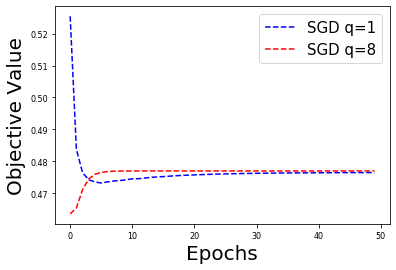

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_sgd_1 = range(len(sgd_objective_val_1))
epochs_sgd_8 = range(len(sgd_objective_val_8))


line0, = plt.plot(epochs_sgd_1, sgd_objective_val_1, '--b', LineWidth=1.5)
line1, = plt.plot(epochs_sgd_8, sgd_objective_val_8, '--r', LineWidth=1.5)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=8)
plt.yticks(FontSize=8)
plt.legend([line0, line1], ['SGD q=1','SGD q=8'], fontsize=15)
plt.show()

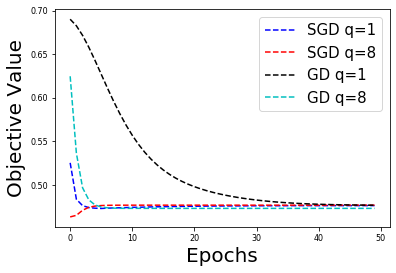

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_sgd_1 = range(len(sgd_objective_val_1))
epochs_sgd_8 = range(len(sgd_objective_val_8))


line0, = plt.plot(epochs_sgd_1, sgd_objective_val_1, '--b', LineWidth=1.5)
line1, = plt.plot(epochs_sgd_8, sgd_objective_val_8, '--r', LineWidth=1.5)
line2, = plt.plot(epochs_gd_1, objective_val_1, '--k', LineWidth=1.5)
line3, = plt.plot(epochs_gd_8, objective_val_8, '--c', LineWidth=1.5)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=8)
plt.yticks(FontSize=8)
plt.legend([line0, line1, line2, line3], ['SGD q=1','SGD q=8', 'GD q=1', 'GD q=8'], fontsize=15)
plt.show()